In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from lorenz_gan.submodels import SubModelGAN
from lorenz_gan.gan import normalize_data, unnormalize_data
import pandas as pd
import pickle
import keras.backend as K
from scipy.signal import cwt, ricker
%matplotlib inline

Using TensorFlow backend.


In [2]:
gan_index = [500, 501, 502, 503, 602, 603]
gan_ds = {}
gan_ds_1 = {}
for gi in gan_index:
    gan_ds[gi] = xr.open_dataset(f"/glade/work/dgagne/exp_20_stoch/v2/gan_{gi}_climate/02000000/lorenz_forecast_02000000_00.nc")
    gan_ds_1[gi] = xr.open_dataset(f"/glade/work/dgagne/exp_20_stoch/gan_{gi}_climate/02000000/lorenz_forecast_02000000_00.nc")

In [36]:
with open("/glade/work/dgagne/exp_20_stoch/offline/ar1/ar1_random_updater_0502.pkl", "rb") as ar1_file:
    ar1 = pickle.load(ar1_file)
print(ar1.corr, ar1.noise_sd)

Using TensorFlow backend.


0.9039780000000001 0.427579


In [40]:
r_ts = np.zeros(5000)
for i in range(1, len(r_ts)):
    r_ts[i] = ar1.update(np.array([r_ts[i-1]]))

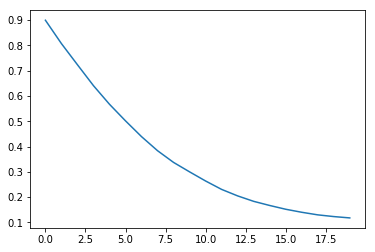

In [51]:
lag_corr = np.zeros(20)
for i in range(20):
    lag_corr[i] = np.corrcoef(r_ts[i+1:], r_ts[:-i-1])[0, 1]
plt.plot(lag_corr)

In [67]:
gan_ds_1[503]["u_res"].shape

(2000000, 8)

In [103]:
sg = SubModelGAN("/glade/work/dgagne/exp_20_stoch/gan_generator_0502_epoch_0030.h5")

In [211]:
input_vals = np.array([gan_ds[502]['x'][6000:6005, 0].values, gan_ds[502]['u'][6000:6005, 0].values]).T
print(input_vals)

[[ 0.7734047 -2.759713 ]
 [ 0.9066499 -2.5989754]
 [ 1.0400878 -2.4651544]
 [ 1.1716242 -2.1903007]
 [ 1.2996247 -1.8563511]]


In [150]:
np.expand_dims(input_vals.reshape(1, 2), axis=2).shape

(1, 2, 1)

In [213]:
norm_x, _ = normalize_data(np.expand_dims(input_vals, axis=2), sg.x_scaling_values)
print(norm_x, norm_x.shape)

[[[-0.5904691 ]
  [-1.2874838 ]]

 [[-0.56418246]
  [-1.2557733 ]]

 [[-0.53785783]
  [-1.2293732 ]]

 [[-0.51190823]
  [-1.1751499 ]]

 [[-0.48665628]
  [-1.1092682 ]]] (5, 2, 1)


In [180]:
sg.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 17)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
split1d_1 (Split1D)             (None, 1)            0           input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 3)            0           input_1[0][0]                    
                                                                 split1d_1[0][0]                  
__________

In [219]:
rand = np.random.normal(size=(5, 17))
print(unnormalize_data(sg.pred_func([norm_x[:, :, 0], rand, 0])[0], sg.y_scaling_values))
#print(unnormalize_data(sg.model.predict([norm_x[:, :, 0], rand])[0], sg.y_scaling_values))

[[[-2.6648414]]

 [[-2.3479645]]

 [[-2.1391456]]

 [[-1.8577645]]

 [[-1.7608478]]]


In [215]:
print(sg.model.layers[13])
add_out = K.function(sg.model.input + [K.learning_phase()], [sg.model.layers[13].output])
add_out([norm_x[:, :, 0], rand, 1])[0] - add_out([norm_x[:, :, 0], rand, 0])[0]
add_out([norm_x[:, :, 0], rand, 1])[0]

InvalidArgumentError: ConcatOp : Dimensions of inputs should match: shape[0] = [5,2] vs. shape[1] = [1,1]
	 [[Node: concatenate_1/concat = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_input_1_0_0/_457, split1d_1/strided_slice, concatenate_1/concat/axis)]]
	 [[Node: batch_normalization_1/cond/Merge/_461 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_148_batch_normalization_1/cond/Merge", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [229]:
sg.model.layers[13].call()

TypeError: call() missing 1 required positional argument: 'inputs'

In [145]:
input_vals = np.array([gan_ds[502]['x'][6000, 0].values, gan_ds[502]['u'][6000, 0].values])
print(input_vals.reshape(1, 2))
rand = np.random.normal(size=(1, 17))
print(rand)
print(sg.predict(input_vals.reshape(1, 2), rand))

[[ 0.7734047 -2.759713 ]]
[[-0.76817821  0.72699536  0.15826122 -0.80207859  1.34510261  0.49649525
  -2.35067574  0.83169453 -1.17972342  0.05296589 -0.21551119  0.40164
  -1.26970724  1.49127852  0.29026682 -0.95132301  0.68770599]]
[3.9178865]


In [3]:
poly = xr.open_dataset("/glade/work/dgagne/exp_20_stoch/poly_add_climate/02000000/lorenz_forecast_02000000_00.nc")

In [4]:
truth = xr.open_dataset("/glade/work/dgagne/exp_20_stoch/lorenz_output.nc")

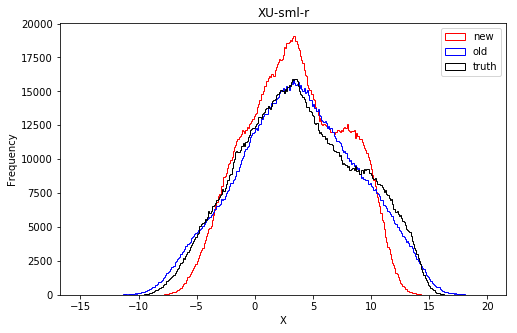

In [48]:
plt.figure(figsize=(8, 5))
bins = np.arange(-15, 20, 0.1)
_ = plt.hist(gan_ds[502]["x"][:, 1], bins=bins, histtype="step", color='red', label="new")
_ = plt.hist(gan_ds_1[502]["x"][:, 1], bins=bins, histtype="step", color='blue', label="old")
_ = plt.hist(truth["lorenz_x"][l_start:l_end, 0], bins=bins, histtype="step", color='k', label="truth")
plt.legend()
plt.xlabel("X")
plt.ylabel("Frequency")
plt.title("XU-sml-r")
plt.savefig("gan_clim_502_old_new.png", dpi=200, bbox_inches="tight")

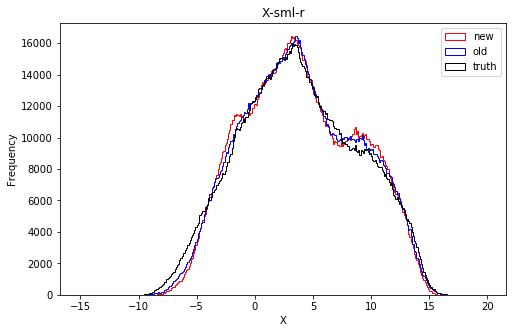

In [47]:
plt.figure(figsize=(8, 5))
bins = np.arange(-15, 20, 0.1)
_ = plt.hist(gan_ds[602]["x"][:, 1], bins=bins, histtype="step", color='red', label="new")
_ = plt.hist(gan_ds_1[602]["x"][:, 1], bins=bins, histtype="step", color='blue', label="old")
_ = plt.hist(truth["lorenz_x"][l_start:l_end, 0], bins=bins, histtype="step", color='k', label="truth")
plt.legend()
plt.xlabel("X")
plt.ylabel("Frequency")
plt.title("X-sml-r")
plt.savefig("gan_clim_602_old_new.png", dpi=200, bbox_inches="tight")

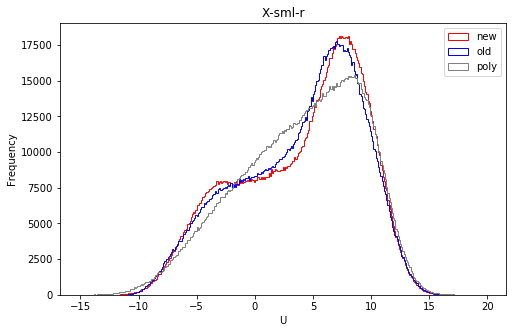

In [50]:
plt.figure(figsize=(8, 5))
bins = np.arange(-15, 20, 0.1)
_ = plt.hist(gan_ds[602]["u"][:, 1], bins=bins, histtype="step", color='red', label="new")
_ = plt.hist(gan_ds_1[602]["u"][:, 1], bins=bins, histtype="step", color='blue', label="old")
_ = plt.hist(poly["u"][:, 1], bins=bins, histtype="step", color='gray', label="poly")

#_ = plt.hist(truth["lorenz_x"][l_start:l_end, 0], bins=bins, histtype="step", color='k', label="truth")
plt.legend()
plt.xlabel("U")
plt.ylabel("Frequency")
plt.title("X-sml-r")
plt.savefig("gan_clim_u_602_old_new.png", dpi=200, bbox_inches="tight")

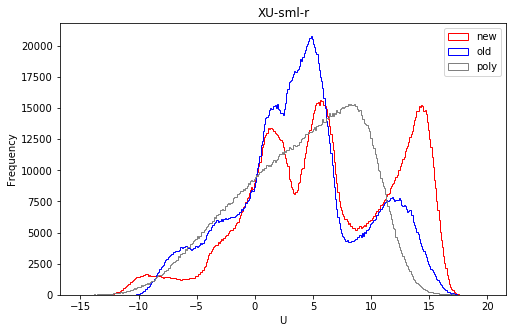

In [51]:
plt.figure(figsize=(8, 5))
bins = np.arange(-15, 20, 0.1)
_ = plt.hist(gan_ds[502]["u"][:, 1], bins=bins, histtype="step", color='red', label="new")
_ = plt.hist(gan_ds_1[502]["u"][:, 1], bins=bins, histtype="step", color='blue', label="old")
_ = plt.hist(poly["u"][:, 1], bins=bins, histtype="step", color='gray', label="poly")

#_ = plt.hist(truth["lorenz_x"][l_start:l_end, 0], bins=bins, histtype="step", color='k', label="truth")
plt.legend()
plt.xlabel("U")
plt.ylabel("Frequency")
plt.title("XU-sml-r")
plt.savefig("gan_clim_u_502_old_new.png", dpi=200, bbox_inches="tight")

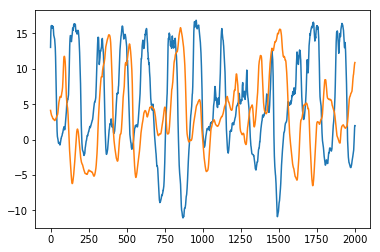

In [20]:
plt.plot(gan_ds[502]["u"][12000:14000, 1])
plt.plot(gan_ds_1[502]["u"][12000:14000, 1])

<BarContainer object of 69 artists>

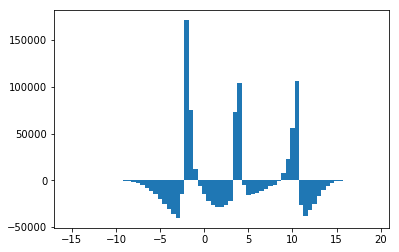

In [18]:
bins = np.arange(-15, 20, 0.5)
hist_new, _ = np.histogram(gan_ds[503]["x"][:, 0], bins=bins)
hist_old, _ = np.histogram(gan_ds_1[503]["x"][:, 0], bins=bins)
diff = hist_new - hist_old
plt.bar(bins[:-1], diff, 0.5)

In [ ]:
/glade/work/dgagne/exp_20_stoch/

In [4]:
ls /glade/work/dgagne/exp_20_stoch/*.nc

/glade/work/dgagne/exp_20_stoch/annres_config_0000_mean.nc
/glade/work/dgagne/exp_20_stoch/annres_config_0000_res.nc
/glade/work/dgagne/exp_20_stoch/lorenz_output.nc


In [6]:
start_index = 2000000
step_values = truth["step"].values
time_values = truth["time"].values

l_start = np.where(step_values == start_index)[0][0]
l_end = l_start + 2000000
truth["lorenz_x"][l_start:l_end, 0].shape

(2000000,)

In [32]:
widths = np.arange(1, 17)
wavelets = np.zeros((len(gan_index), widths.size, gan_ds[500]["x"].shape[0]))
for g, gi in enumerate(gan_index):
    wavelets[g] = cwt(gan_ds[gi]["x"][:, 0], ricker, 2 ** widths)
wout_poly = cwt(poly["x"][:, 0], ricker, 2 ** widths)
wout_truth = cwt(truth["lorenz_x"][l_start:l_end, 0], ricker, 2 ** widths)

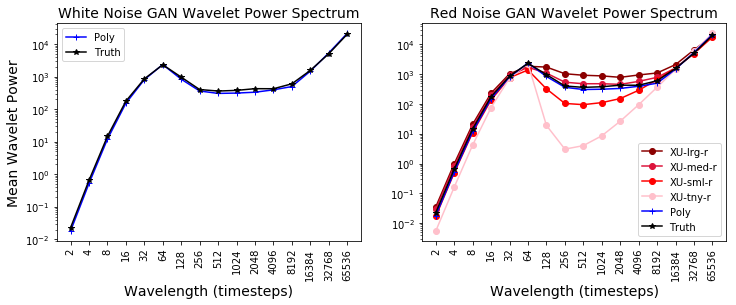

In [34]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
colors =["darkred", "crimson", "red", "pink"]
gan_configs = ["XU-lrg-w", "XU-med-w","XU-sml-w", "XU-tny-w", "XU-lrg-r", "XU-med-r", "XU-sml-r", "XU-tny-r"]
#for i in range(4):
#    plt.plot(widths, np.mean(wavelets[i] ** 2, axis=1), marker='o', color=colors[i], label=gan_configs[i])
plt.plot(widths, np.mean(wout_poly ** 2, axis=1), marker='+', color="blue", label="Poly")
plt.plot(widths, np.mean(wout_truth ** 2, axis=1), marker='*', color='k', label="Truth")

plt.xticks(widths, 2 ** widths, rotation=90)
plt.legend()
plt.gca().set_yscale("log")
plt.xlabel("Wavelength (timesteps)", fontsize=14)
plt.ylabel("Mean Wavelet Power", fontsize=14)
plt.title("White Noise GAN Wavelet Power Spectrum", fontsize=14)
plt.subplot(1, 2, 2)
for i in range(4, 8):
    plt.plot(widths, np.mean(wavelets[i-4] ** 2, axis=1), marker='o', color=colors[i-4], label=gan_configs[i])
plt.plot(widths, np.mean(wout_poly ** 2, axis=1), marker='+', color="blue", label="Poly")
plt.plot(widths, np.mean(wout_truth ** 2, axis=1), marker='*', color='k', label="Truth")
plt.xticks(widths, 2 ** widths, rotation=90)
plt.gca().set_yscale("log")

plt.title("Red Noise GAN Wavelet Power Spectrum", fontsize=14)
plt.legend()
plt.xlabel("Wavelength (timesteps)", fontsize=14)
plt.savefig("gan_climate_wavelet_power.pdf", bbox_inches="tight")
plt.savefig("gan_climate_wavelet_power.png", dpi=200, bbox_inches="tight")

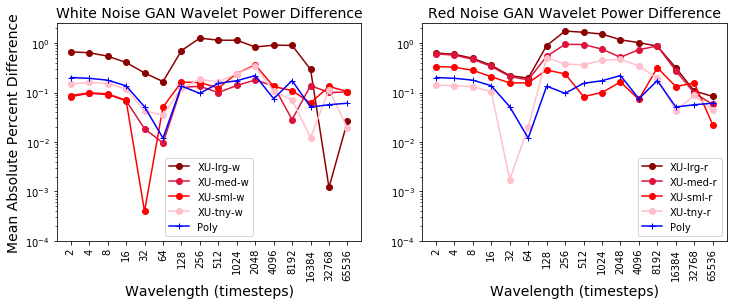

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
colors =["darkred", "crimson", "red", "pink"]
gan_configs = ["XU-lrg-w", "XU-med-w","XU-sml-w", "XU-tny-w", "XU-lrg-r", "XU-med-r", "XU-sml-r", "XU-tny-r"]
truth_power = np.mean(wout_truth ** 2, axis=1)
for i in range(4):
    plt.plot(widths, np.abs(np.mean(wavelets[i] ** 2, axis=1) - truth_power) / truth_power, marker='o', color=colors[i], label=gan_configs[i])
plt.plot(widths, np.abs(np.mean(wout_poly ** 2, axis=1) - truth_power) / truth_power, marker='+', color="blue", label="Poly")
plt.xticks(widths, 2 ** widths, rotation=90)
plt.ylim(0.0001, 2.5)
plt.gca().set_yscale("log")
plt.legend()
plt.xlabel("Wavelength (timesteps)", fontsize=14)
plt.ylabel("Mean Absolute Percent Difference", fontsize=14)
plt.title("White Noise GAN Wavelet Power Difference", fontsize=14)
plt.subplot(1, 2, 2)
for i in range(4, 8):
    plt.plot(widths, np.abs((np.mean(wavelets[i] ** 2, axis=1) - truth_power)) / truth_power, marker='o', color=colors[i-4], label=gan_configs[i])
plt.plot(widths, np.abs(np.mean(wout_poly ** 2, axis=1) - truth_power) / truth_power, marker='+', color="blue", label="Poly")
plt.xticks(widths, 2 ** widths, rotation=90)
plt.ylim(0.0001, 2.5)
plt.gca().set_yscale("log")
plt.title("Red Noise GAN Wavelet Power Difference", fontsize=14)
plt.legend()
plt.xlabel("Wavelength (timesteps)", fontsize=14)
plt.savefig("gan_climate_wavelet_power_diff.pdf", bbox_inches="tight")
plt.savefig("gan_climate_wavelet_power_diff.png", dpi=200, bbox_inches="tight")

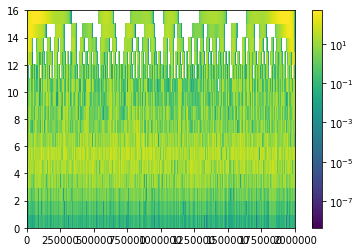

In [34]:
plt.pcolormesh(wout_truth, norm=LogNorm())
plt.colorbar()

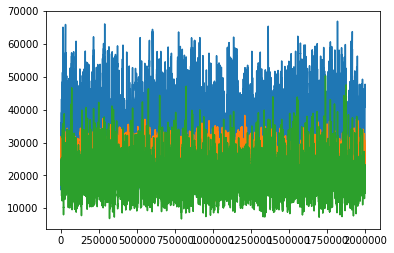

In [119]:
plt.plot(pd.Series(np.abs(wout_gan_302[5])).rolling(1000).sum())
plt.plot(pd.Series(np.abs(wout_gan_302[4])).rolling(1000).sum())
plt.plot(pd.Series(np.abs(wout_gan_302[6])).rolling(1000).sum())

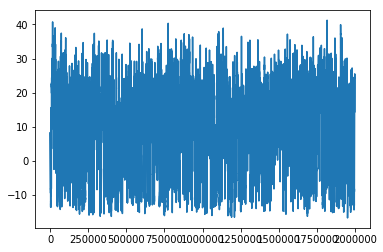

In [124]:
plt.plot(pd.Series(np.abs(wout_gan_302[5]) - np.abs(wout_gan_302[4])).rolling(1000).mean())
